# Signal identification and background estimation

Signal identification is one of the first step of the analysis workflow. It consist on selecting the time period where the signal occurred, as well as other time periods before (and possibbly after) that will be use to compute the background.

In bc-tool the signal identification and background calculation is performed itertively using [bayesian blocks](https://arxiv.org/abs/1304.2818). Each iteration fits the background with a polynomial, identifies peaks, and then removes them from the data use to fit the background in the next iteration. This continue until it converges. 

### Imports

In [1]:
from gdt.missions.fermi.gbm.tte import GbmTte
from gdt.core.binning.unbinned import bin_by_time
from gdt.core.binning.binned import rebin_by_time

from bctools.analysis import BayesianBlocksLightcurve

import numpy as np
import urllib

### Get the light curve

For this example will use real GBM's data. We'll start with event data (TTE) and binned it into a light curve.

In [2]:
# Long GRB example
filename,_ = urllib.request.urlretrieve("https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/triggers/2021/bn210925800/current/glg_tte_n6_bn210925800_v00.fit")

# Short GRB example
#filename,_ = urllib.request.urlretrieve("https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/triggers/2009/bn090120627/current/glg_tte_n5_bn090120627_v01.fit")

tte = GbmTte.open(filename)

Now let's select and energy range and bin the data in time to create a light curve. The algorithm correctly handles Poisson statistics, so you can bin the data very finely if you wish. 

In [3]:
# Bin in time (32ms)
phaii = tte.to_phaii(bin_by_time, 0.032, time_ref=0.0, energy_range = (50.0, 300.0))

lc = phaii.to_lightcurve()

The ``BayesianLightcurve`` class performs the Bayesian blocks calculations, as well as the background fitting and signal identification:

In [4]:
bb_lc = BayesianBlocksLightcurve(lc)

### Identify signal

The meat of the calculation is performed by ``compute_bayesian_blocks``. It iteratively fits the background, identifies the signal, and bins the light curve in Bayesian blocks. You can call it directly and the results will be cache for the other methods, or alternatively the other methods will call it for you with default parameters. 

In [5]:
%%time
bb_lc.compute_bayesian_blocks()

CPU times: user 10.3 s, sys: 864 ms, total: 11.1 s
Wall time: 8.76 s


Now we can get the start and stop times of the signal.

In [6]:
bb_lc.signal_range

<TimeRange: (-6.944, 236.352)>

### Plot

You can use the `plot()` method for a quick view of the light curve. If you want to fine tune your plot, you can always obtain the underlaying data with the properties `lightcurve`, `bb_lightcurve` and `bkg_model`.

<Axes: >

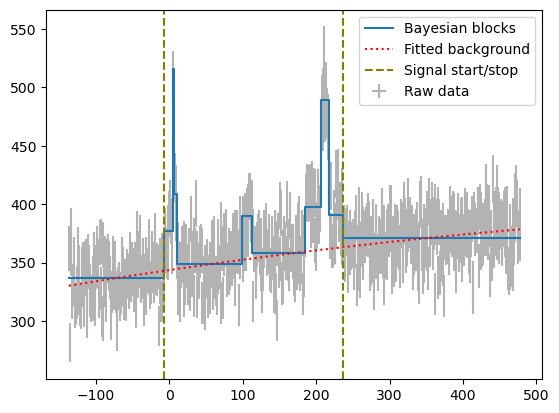

In [7]:
bb_lc.plot(rebin_dt = 1)

### Get burst duration

We can compute duration values like the T90. We defined it as the time length of the period between which 5% and 95% of the accumulated background-subtracted counts in the identified signal were detected.

In [8]:
bb_lc.duration(quantile = .9)

229.3461180481858

In order to estimate the error in the burst duration, bctools takes the Bayesian blocks representation of the light curve and the background fit, generates multiple poisson-fluctuated light curve samples, and repeats the duration calculation. For finely binned light curves over a long time span, this can be unfortunately quite slow.  While ideally we would need ~100 samples in orde compute the 68% cont. error, ~10 samples can give you an preliminary order of magnitude estimate in a resonable time.

In [9]:
%%time

bb_lc.duration_error(.9, nsamples = 10)

CPU times: user 2min, sys: 7.02 s, total: 2min 7s
Wall time: 1min 32s


array([-3.21587195,  1.05369836])